In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import matplotlib as mpl
from scipy.ndimage import gaussian_filter1d


# Load dataset
df = pd.read_csv('/Users/emircanince/Desktop/power/data/causal_data.csv')
df = df[df['solar_penetration'] != 0]
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Extract necessary columns
df = df[['solar_penetration', 'electricity_price']]

# Sort the dataset by penetration for smoother sliding window
df = df.sort_values('solar_penetration')

# Define window size and step size
window_size = 5000
step_size = 500

# Initialize lists to store results
mean_penetrations = []
mean_prices = []
ci_lower = []
ci_upper = []


# Bootstrap function to calculate mean and CI
def apply_bootstrap(data, n_resamples=1000):
    # Perform bootstrap resampling
    res = bootstrap((data,), np.mean, n_resamples=n_resamples, method='basic', confidence_level=0.80)
    return res.confidence_interval.low, res.confidence_interval.high, np.mean(data)


# Slide over the dataset with the specified window and step
for i in range(0, len(df) - window_size + 1, step_size):
    # Select the current window of 10,000 observations
    window = df.iloc[i:i + window_size]

    # Extract the data for bootstrap
    penetration_data = window['solar_penetration'].values
    price_data = window['electricity_price'].values

    # Perform bootstrap for solar penetration and price
    penetration_ci_low, penetration_ci_high, penetration_mean = apply_bootstrap(penetration_data)
    price_ci_low, price_ci_high, price_mean = apply_bootstrap(price_data)

    # Store the results
    mean_penetrations.append(penetration_mean)
    mean_prices.append(price_mean)
    ci_lower.append(price_ci_low)
    ci_upper.append(price_ci_high)

# Load solar results
results_dataset_solar = pd.read_csv('/Users/emircanince/Desktop/power/data/results_solar.csv')

# Group by mean solar penetration and calculate mean and quantiles for CATE
mean_cate_df_solar = results_dataset_solar.groupby('mean_solar_penetration')['cate'].agg(['mean']).reset_index()
mean_cate_df_solar['lower_ci'] = results_dataset_solar.groupby('mean_solar_penetration')['cate'].quantile(0.1).values
mean_cate_df_solar['upper_ci'] = results_dataset_solar.groupby('mean_solar_penetration')['cate'].quantile(0.9).values

# Apply Gaussian smoothing
# sigma_smoothing = np.var(mean_cate_df_solar['mean'])
sigma_smoothing = 1.5 * np.std(mean_cate_df_solar['mean'])
mean_cate_df_solar['smoothed_mean'] = gaussian_filter1d(mean_cate_df_solar['mean'], sigma=sigma_smoothing)
mean_cate_df_solar['smoothed_lower_ci'] = gaussian_filter1d(mean_cate_df_solar['lower_ci'], sigma=sigma_smoothing)
mean_cate_df_solar['smoothed_upper_ci'] = gaussian_filter1d(mean_cate_df_solar['upper_ci'], sigma=sigma_smoothing)

# Set Helvetica font globally
plt.rcParams.update({
    'font.family': 'Helvetica',
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'axes.labelsize': 16
})

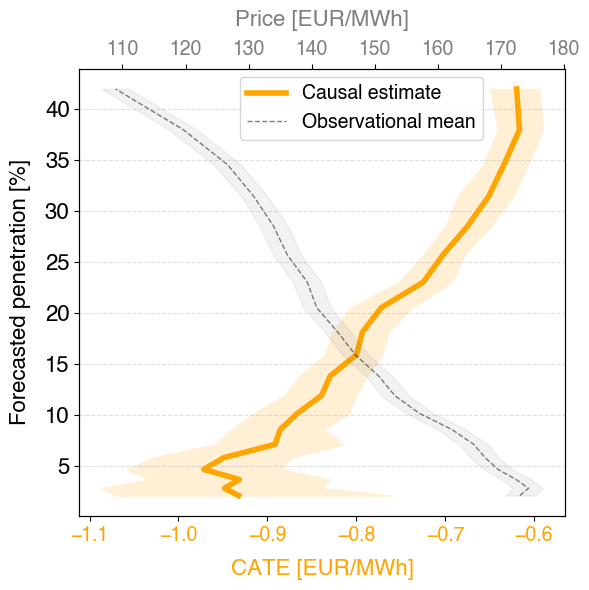

In [6]:
# Create a plot with shared y-axis for penetration
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=100)
ax1.plot(mean_cate_df_solar['smoothed_mean'], mean_cate_df_solar['mean_solar_penetration'],
         color='orange', label='Causal estimate', lw=4)
ax1.fill_betweenx(mean_cate_df_solar['mean_solar_penetration'],
                  mean_cate_df_solar['smoothed_lower_ci'],
                  mean_cate_df_solar['smoothed_upper_ci'],
                  color='papayawhip', alpha=1)  # Orange fill
ax1.set_xlabel('CATE [EUR/MWh]', color='orange', fontsize=16, labelpad=10)
ax1.set_ylabel('Forecasted penetration [%]', fontsize=16, labelpad=10)
ax1.tick_params(axis='x', labelcolor='orange', labelsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax2 = ax1.twiny()  # Create a secondary x-axis sharing the same y-axis
ax2.plot(mean_prices, mean_penetrations, color='k', label='Observational mean', lw=1, alpha=.5, ls='--')
ax2.fill_betweenx(mean_penetrations, ci_lower, ci_upper, color='gray', alpha=0.1)  # Crimson fill
ax2.set_xlabel('Price [EUR/MWh]', color='gray', fontsize=16, labelpad=10)
ax2.tick_params(axis='x', labelcolor='gray', labelsize=14)
fig.legend(fontsize=14, ncol=1, bbox_to_anchor=(0.83, 0.88), frameon=True)
plt.tight_layout()
# Save the plot
# plt.savefig('/Users/emircanince/Desktop/power/renewables/png/mean_vs_cate_solar.png', format='png', dpi=600)
plt.show()